In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUS

In [2]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model
from keras.layers import (Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Dropout, Dense, Flatten)
from keras.callbacks import EarlyStopping

In [3]:
train_image_mask = {'images': [], 'masks': []}
test_image_mask = {'images': [], 'masks': []}

train_image_class = {'images': [], 'labels': []}
test_image_class = {'images': [], 'labels': []}

def load_image_mask(train_image_mask, test_image_mask, image_path, shape=256):
    file_names = os.listdir(image_path)
    partial_names = list(set(fn.split(')')[0] for fn in file_names))
    image_names = [name + ').png' for name in partial_names]
    mask_names = [name + ')_mask.png' for name in partial_names]
    
    train_test_split_index = int(len(image_names) * 0.8)
    
    for i, (image_name, mask_name) in enumerate(zip(image_names, mask_names)):
        image = cv2.resize(plt.imread(os.path.join(image_path, image_name)), (shape, shape))
        mask = cv2.resize(plt.imread(os.path.join(image_path, mask_name)), (shape, shape))
        
        if i < train_test_split_index:
            train_image_mask['images'].append(image)
            train_image_mask['masks'].append(mask)
        else:
            test_image_mask['images'].append(image)
            test_image_mask['masks'].append(mask)
    
    return train_image_mask, test_image_mask

def load_image_class(train_image_class, test_image_class, image_path, shape=256):
    file_names = os.listdir(image_path)
    image_class = os.path.basename(image_path)
    image_names = [fn.split(')')[0] + ').png' for fn in file_names]
    
    train_test_split_index = int(len(image_names) * 0.8)
    
    for i, image_name in enumerate(image_names):
        image = cv2.resize(plt.imread(os.path.join(image_path, image_name)), (shape, shape))
        
        if i < train_test_split_index:
            train_image_class['images'].append(image)
            train_image_class['labels'].append(image_class)
        else:
            test_image_class['images'].append(image)
            test_image_class['labels'].append(image_class)
    
    return train_image_class, test_image_class

In [4]:
from pathlib import Path

base_dir = Path("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT")
categories = ['normal', 'benign', 'malignant']

for category in categories:
    image_dir = base_dir / category / 'images'
    mask_dir = base_dir / category / 'masks'

    print(f"Category: '{category}'")
    
    if image_dir.exists() and image_dir.is_dir():
        print(f"Images directory exists: {image_dir}")
        images = list(image_dir.iterdir())
        print(f"Number of images: {len(images)}")
    else:
        print(f"Error: Images directory does not exist: {image_dir}")
        images = []

    if mask_dir.exists() and mask_dir.is_dir():
        print(f"Masks directory exists: {mask_dir}")
        masks = list(mask_dir.iterdir())
        print(f"Number of masks: {len(masks)}")
    else:
        print(f"Error: Masks directory does not exist: {mask_dir}")
        masks = []

    print("-" * 50)

Category: 'normal'
Error: Images directory does not exist: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/images
Error: Masks directory does not exist: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/masks
--------------------------------------------------
Category: 'benign'
Error: Images directory does not exist: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/images
Error: Masks directory does not exist: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/masks
--------------------------------------------------
Category: 'malignant'
Error: Images directory does not exist: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/images
Error: Masks directory does not exist: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/masks
--------------------------------------------------


In [5]:
categories = ['benign', 'malignant']

for category in categories:
    category_path = f"/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/{category}"

    train_image_mask, test_image_mask = load_image_mask(
        train_image_mask=train_image_mask,
        test_image_mask=test_image_mask,
        image_path=category_path
    )

    train_image_class, test_image_class = load_image_class(
        train_image_class=train_image_class,
        test_image_class=test_image_class,
        image_path=category_path
    )

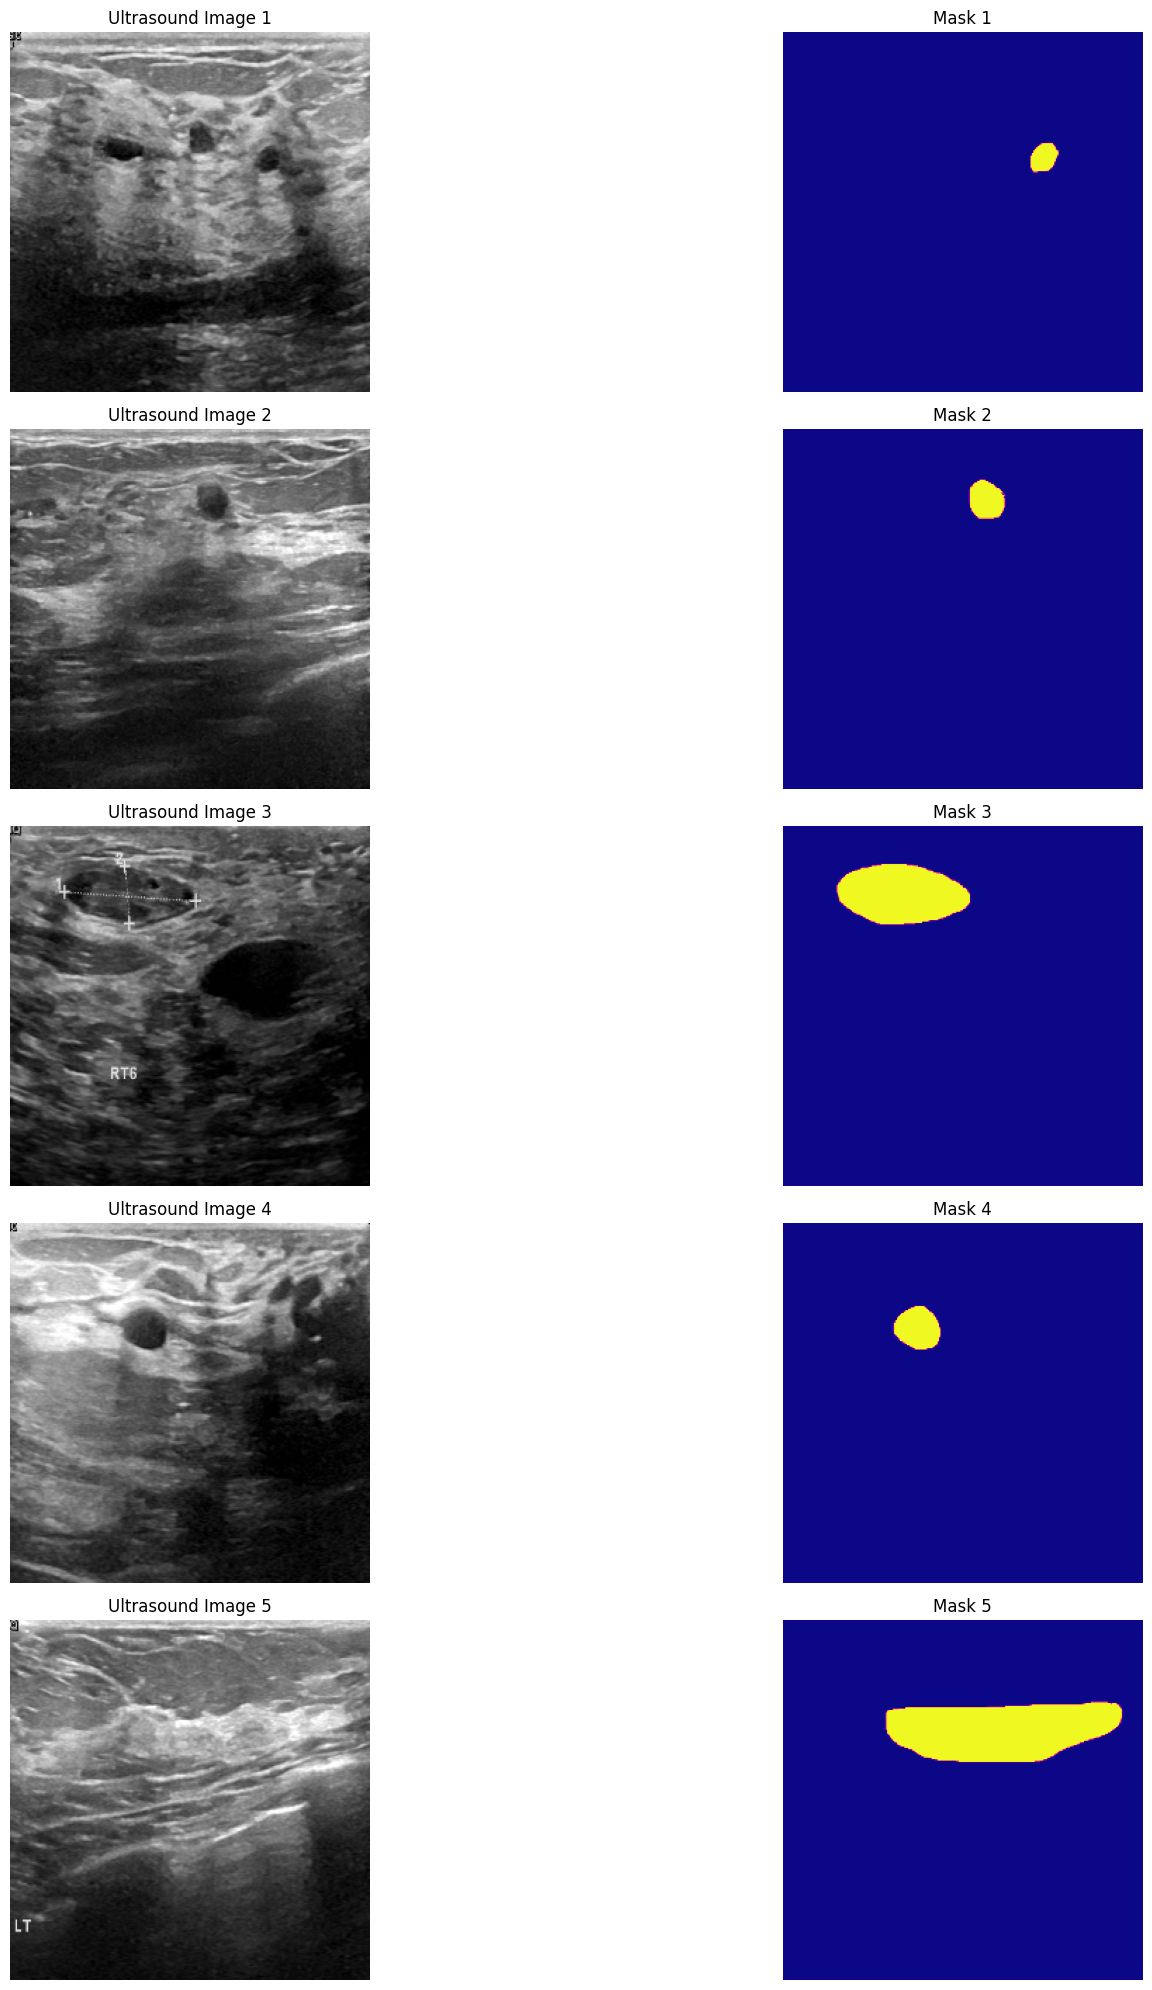

In [6]:
plt.figure(figsize=(20, 20))

for i in range(5):
    
    plt.subplot(5, 2, i * 2 + 1)
    plt.imshow(train_image_mask['images'][i])
    plt.title(f'Ultrasound Image {i+1}')
    plt.axis('off')

   
    plt.subplot(5, 2, i * 2 + 2)
    plt.imshow(train_image_mask['masks'][i], cmap='plasma')
    plt.title(f'Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
def convolution_block(input_tensor, num_filters, kernel_size=3, dropout_rate=0.1):
    """
    A block of 2 convolutional layers with BatchNormalization and ReLU activations.
    """
    x = Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), 
               kernel_initializer='he_normal', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), 
               kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dropout(dropout_rate)(x)
    return x

def unet_model(input_tensor, initial_filters=16, dropout_rate=0.1):
    """
    Builds a U-Net model with an encoder-decoder architecture for image segmentation.
    """
    # Encoder Path
    enc1 = convolution_block(input_tensor, initial_filters, dropout_rate=dropout_rate)
    enc1_pool = AveragePooling2D((2, 2))(enc1)

    enc2 = convolution_block(enc1_pool, initial_filters * 2, dropout_rate=dropout_rate)
    enc2_pool = AveragePooling2D((2, 2))(enc2)

    enc3 = convolution_block(enc2_pool, initial_filters * 4, dropout_rate=dropout_rate)
    enc3_pool = AveragePooling2D((2, 2))(enc3)

    enc4 = convolution_block(enc3_pool, initial_filters * 8, dropout_rate=dropout_rate)
    enc4_pool = AveragePooling2D((2, 2))(enc4)

    bottleneck = convolution_block(enc4_pool, initial_filters * 16, dropout_rate=dropout_rate)

    dec1 = Conv2DTranspose(initial_filters * 8, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    dec1 = concatenate([dec1, enc4])
    dec1 = Dropout(dropout_rate)(dec1)
    dec1 = convolution_block(dec1, initial_filters * 8, dropout_rate=dropout_rate)

    dec2 = Conv2DTranspose(initial_filters * 4, (3, 3), strides=(2, 2), padding='same')(dec1)
    dec2 = concatenate([dec2, enc3])
    dec2 = Dropout(dropout_rate)(dec2)
    dec2 = convolution_block(dec2, initial_filters * 4, dropout_rate=dropout_rate)

    dec3 = Conv2DTranspose(initial_filters * 2, (3, 3), strides=(2, 2), padding='same')(dec2)
    dec3 = concatenate([dec3, enc2])
    dec3 = Dropout(dropout_rate)(dec3)
    dec3 = convolution_block(dec3, initial_filters * 2, dropout_rate=dropout_rate)

    dec4 = Conv2DTranspose(initial_filters, (3, 3), strides=(2, 2), padding='same')(dec3)
    dec4 = concatenate([dec4, enc1])
    dec4 = Dropout(dropout_rate)(dec4)
    dec4 = convolution_block(dec4, initial_filters, dropout_rate=dropout_rate)

    output = Conv2D(1, (1, 1), activation='sigmoid')(dec4)

    model = Model(inputs=input_tensor, outputs=output)
    return model

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [9]:
inputs = Input((256, 256, 3))
segmentation_model = unet_model(inputs, initial_filters=16, dropout_rate=0.1)
segmentation_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = segmentation_model.fit(
    np.array(train_image_mask['images']), 
    np.array(train_image_mask['masks']),
    epochs=5,
    validation_data=(
        np.array(test_image_mask['images']), 
        np.array(test_image_mask['masks'])
    ),
    callbacks=[
        EarlyStopping(
            patience=15, 
            monitor='val_loss', 
            mode='min', 
            restore_best_weights=True, 
            verbose=1
        )
    ]
)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5495 - loss: 0.7555 - val_accuracy: 0.3698 - val_loss: 8.7832
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.8672 - loss: 0.4912 - val_accuracy: 0.1170 - val_loss: 9.9966
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.9002 - loss: 0.4041 - val_accuracy: 0.2532 - val_loss: 10.0284
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.9027 - loss: 0.3670 - val_accuracy: 0.5759 - val_loss: 4.6226
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.9066 - loss: 0.3507 - val_accuracy: 0.5891 - val_loss: 1.3930
Restoring model weights from the end of the best epoch: 5.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

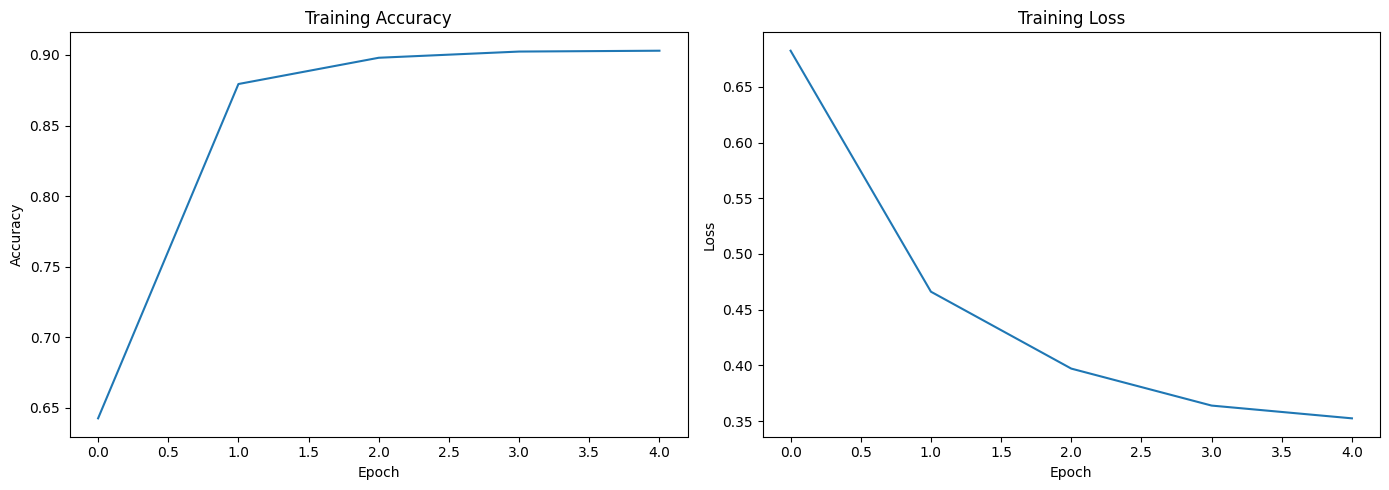

In [12]:
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

history_df = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': accuracy,
    'Loss': loss
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(data=history_df, x='Epoch', y='Accuracy', ax=axes[0])
axes[0].set_title('Training Accuracy')

sns.lineplot(data=history_df, x='Epoch', y='Loss', ax=axes[1])
axes[1].set_title('Training Loss')

plt.tight_layout()
plt.show()

In [14]:
testImages = test_image_mask['images']
testMasks = test_image_mask['masks']

predictions = segmentation_model.predict(np.array(testImages))
print(predictions.shape)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step
(130, 256, 256, 1)


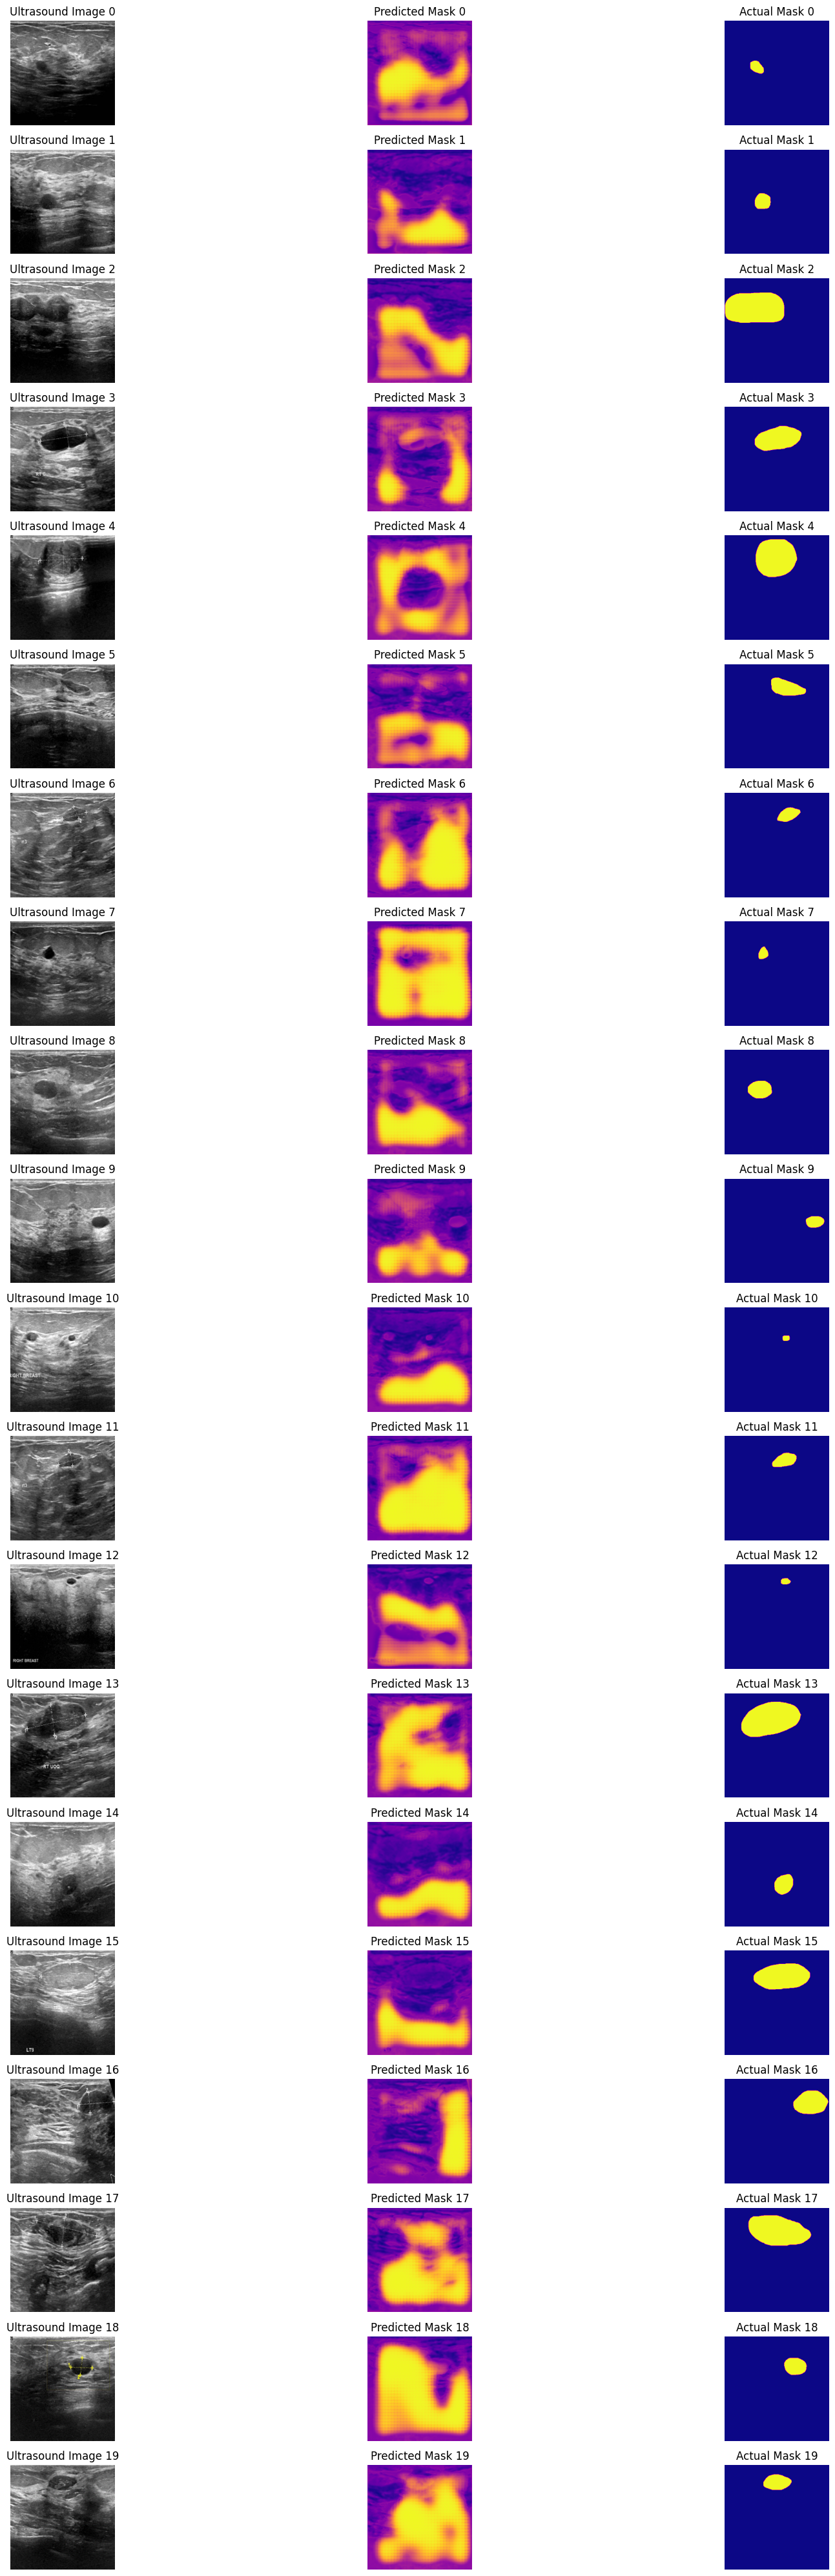

In [15]:

def plot_image_mask_comparisons(test_images, predictions, test_masks, indices, figsize=(20, 40)):
    """
    Plots ultrasound images, predicted masks, and actual masks side by side for comparison.

    Parameters:
        test_images (list/ndarray): List or array of test ultrasound images.
        predictions (list/ndarray): List or array of predicted masks.
        test_masks (list/ndarray): List or array of actual masks.
        indices (list): Indices of images to plot.
        figsize (tuple): Size of the figure.
    """
    num_samples = len(indices)
    plt.figure(figsize=figsize)

    for i, idx in enumerate(indices):
        # Plot Ultrasound Image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(test_images[idx])
        plt.title(f'Ultrasound Image {idx}')
        plt.axis('off')

        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(predictions[idx], cmap='plasma')
        plt.title(f'Predicted Mask {idx}')
        plt.axis('off')

        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(test_masks[idx], cmap='plasma')
        plt.title(f'Actual Mask {idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


indices_to_plot = list(range(20))  
plot_image_mask_comparisons(testImages, predictions, testMasks, indices_to_plot, figsize=(20, 40))